# DPIN

FLOW TOXICITY AND LIQUIDITY IN A HIGH FREQUENCY WORLD 의 VPIN 참고  
[H.Y. KIM] Dive into VPIN Algorithm 발표 영상(유투브) 참고

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
code = '005930'
df = pd.read_csv(f"./{code}_dollar_bar_80mean_50div.csv", index_col=0, parse_dates=True)
df.tail(3)

,open,high,low,close,trading_value,buy_taking_trading_value,sell_taking_trading_value
datetime,,,,,,,
2021-08-11 15:14:52.605772,78700.0,78700.0,78600.0,78600.0,2.562071e+10,6.759936e+09,1.886078e+10
2021-08-11 15:17:29.629648,78700.0,78700.0,78600.0,78600.0,2.542255e+10,6.065960e+09,1.935659e+10
2021-08-11 15:19:26.664158,78700.0,78700.0,78500.0,78500.0,1.934468e+11,1.442964e+09,1.057516e+10


## Method 1

tick data 에 mark 된 order side 에 따라 매수량, 매도량 계산

In [3]:
def get_dpin_series_method_1(df: pd.DataFrame, window: int):
    df = df[[
        'buy_taking_trading_value',
        'sell_taking_trading_value',
        'trading_value'
    ]].copy()

    # 데이터가 온전하지 않는 경우 핸들링 =====================================================================
    df['lag_1_buy_taking_trading_value'] = df['buy_taking_trading_value'].shift(1)
    df['lag_1_sell_taking_trading_value'] = df['sell_taking_trading_value'].shift(1)

    error_data = ((df['buy_taking_trading_value'] + df['lag_1_buy_taking_trading_value']) == 0) & \
                 ((df['sell_taking_trading_value'] + df['lag_1_sell_taking_trading_value']) == 0)
    df.loc[error_data, 'buy_taking_trading_value'] = np.nan
    df.loc[error_data, 'sell_taking_trading_value'] = np.nan
    # =====================================================================================================

    df['order_imbalance'] = (df['sell_taking_trading_value'] - df['buy_taking_trading_value']).abs()
    df['rolling_order_imbalance'] = df['order_imbalance'].rolling(window=window).sum()

    # bucket size 대체
    df['rolling_trading_value'] = df['trading_value'].rolling(window=window).sum()

    dpin_series = df['rolling_order_imbalance'] / df['rolling_trading_value']
    return dpin_series

In [4]:
get_dpin_series_method_1(df, 50).tail(3)

datetime
2021-08-11 15:14:52.605772    0.444700
2021-08-11 15:17:29.629648    0.450773
2021-08-11 15:19:26.664158    0.400023
dtype: float64

## Method 2

가격 변화에 따라, 매수량, 매도량 추정

In [5]:
def get_dpin_series_method_2(df: pd.DataFrame, window: int):
    df = df[[
        'close',
        'trading_value'
    ]].copy()

    # TODO 미리보기 편향 존재. 추후 rolling으로 수정
    df['buy_power'] = df['close'].pct_change() / df['close'].pct_change().std()
    df['buy_ratio'] = stats.norm.cdf(df['buy_power'])

    df['buy_taking_trading_value'] = df['trading_value'] * df['buy_ratio']
    df['sell_taking_trading_value'] = df['trading_value'] - df['buy_taking_trading_value']

    df['order_imbalance'] = (df['sell_taking_trading_value'] - df['buy_taking_trading_value']).abs()
    df['rolling_order_imbalance'] = df['order_imbalance'].rolling(window=window).sum()

    # bucket size 대체
    df['rolling_trading_value'] = df['trading_value'].rolling(window=window).sum()

    dpin_series = df['rolling_order_imbalance'] / df['rolling_trading_value']
    return dpin_series

In [6]:
get_dpin_series_method_2(df, 50).tail(3)

datetime
2021-08-11 15:14:52.605772    0.260604
2021-08-11 15:17:29.629648    0.260940
2021-08-11 15:19:26.664158    0.302245
dtype: float64

## DPIN 비교

In [7]:
df['dpin_1'] = get_dpin_series_method_1(df, 100)
df['dpin_2'] = get_dpin_series_method_2(df, 100)

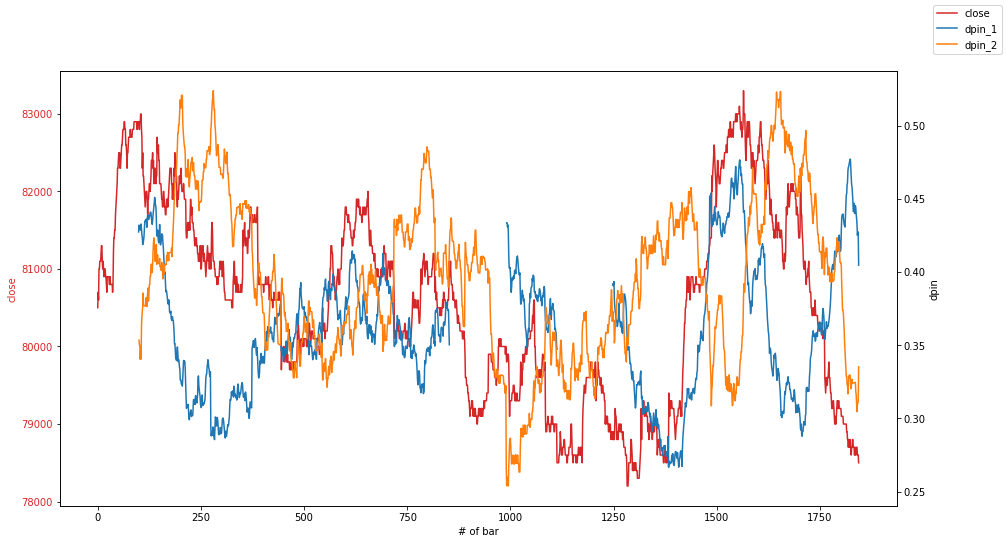

In [8]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(len(df.index))
data1 = df['close']
data2 = df[['dpin_1', 'dpin_2']]

fig, ax1 = plt.subplots(figsize=(15,8))

color = 'tab:red'
ax1.set_xlabel('# of bar')
ax1.set_ylabel('close', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylabel('dpin')
ax2.plot(t, data2)
ax2.tick_params(axis='y')

fig.legend(['close', 'dpin_1', 'dpin_2'])
plt.show()

## DPIN CDF 비교

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF

dpin_1_cdf = ECDF(df['dpin_1'].dropna())
dpin_2_cdf = ECDF(df['dpin_2'].dropna())

In [10]:
df['dpin_1_cdf'] = df['dpin_1'].apply(lambda x: np.nan if np.isnan(x) else dpin_1_cdf(x))
df['dpin_2_cdf'] = df['dpin_2'].apply(lambda x: np.nan if np.isnan(x) else dpin_2_cdf(x))

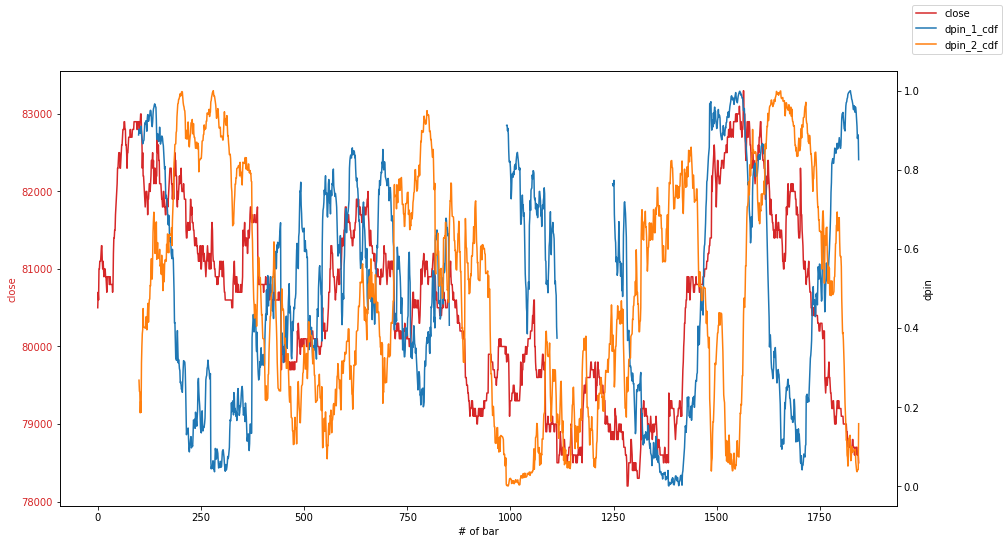

In [11]:
t = np.arange(len(df.index))
data1 = df['close']
data2 = df[['dpin_1_cdf', 'dpin_2_cdf']]

fig, ax1 = plt.subplots(figsize=(15,8))

color = 'tab:red'
ax1.set_xlabel('# of bar')
ax1.set_ylabel('close', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylabel('dpin')
ax2.plot(t, data2)
ax2.tick_params(axis='y')

fig.legend(['close', 'dpin_1_cdf', 'dpin_2_cdf'])
plt.show()